In [8]:
# =============================================================================
# Parametric Insurance Engine - Cumulative Index & Financial Payout
#
# This script simulates a parametric insurance model where:
# 1. The trigger is based on a 7-Day Cumulative Rainfall Index.
# 2. Payouts are defined financially and tied to a variance-based trigger.
# 3. Checks are strictly applied within a defined Policy Period.
# =============================================================================

# Install IMDLIB, pandas, numpy, and matplotlib (essential for data processing and plotting)
!pip install imdlib pandas numpy matplotlib

# Import necessary libraries
import imdlib as imd
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xarray # Explicitly import xarray for advanced processing


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [10]:
# =============================================================================
# 1. Define Policy and Model Parameters
# =============================================================================

# Define the target geographical point (e.g., a city in India)
TARGET_LAT = 19.0760  # Example: Mumbai, Maharashtra
TARGET_LON = 72.8777

# --- Policy/Contractual Parameters ---
FULL_PAYOUT_AMOUNT = 10000.0  # Maximum payout amount (e.g., in INR or USD)
CUMULATIVE_DAYS = 7           # The period over which rainfall is aggregated (the Index Period)
POLICY_START_DATE = '2025-06-01'
POLICY_END_DATE = '2025-12-12' # NOTE: Current date is outside this period, so the first step will correctly result in an inactive policy.

# --- Model Parameters ---
LPA_START_YR = 1981
LPA_END_YR = 2010 
STD_DEV_MULTIPLIER = 1.25      # Partial Payout Start Trigger (LPA + N * Std Dev)
FINAL_HIGH_RAINFALL_THRESHOLD_MM = 150.0 # Fixed maximum cumulative trigger for Full Payout

# Directory for IMDLIB data storage
DATA_DIR = 'IMD_Rain_Data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)




In [4]:
# =============================================================================
# 2. Core Data Retrieval and Processing Functions
# =============================================================================

def ensure_historical_data_exists(file_dir, start_yr, end_yr):
    """Checks for and downloads historical IMD data if missing."""
    print(f"\n--- Ensuring Historical IMD Data ({start_yr}-{end_yr}) is Local ---")
    
    all_files_exist = True
    for year in range(start_yr, end_yr + 1):
        # Note: Historical data is downloaded year-wise to form the climatology
        data_path = os.path.join(file_dir, 'rain', f'{year}.grd')
        if not os.path.exists(data_path):
            all_files_exist = False
            break 
    
    if all_files_exist:
        print(f"All historical data files already exist locally. Skipping download.")
        return True
    
    print("Historical data not fully found. Initiating full range download (this may take time)...")
    try:
        imd.get_data('rain', start_yr, end_yr, fn_format='yearwise', file_dir=file_dir)
        print("Download complete.")
        return True
    except Exception as e:
        print(f"FATAL ERROR during download: {e}")
        return False


def get_climatological_data(lat, lon):
    """
    Calculates the Long Period Average (LPA) and Standard Deviation (Std Dev) 
    of DAILY rainfall from the local historical IMD data (1981-2010).
    The resulting thresholds will be scaled later by CUMULATIVE_DAYS.
    Returns: (LPA_mean_mm, Std_Dev_mm)
    """
    print(f"\n--- Calculating Climatological LPA and Std Dev ---")
    try:
        data = imd.open_data('rain', LPA_START_YR, LPA_END_YR, 'yearwise', file_dir=DATA_DIR)
        ds = data.get_xarray()
        
        # Select the data for the nearest grid point
        regional_ds = ds.sel(lat=lat, lon=lon, method='nearest')['rain']
        
        # Filter out missing values (-999.0)
        clean_rainfall = regional_ds.where(regional_ds != -999.0).values.flatten()
        clean_rainfall = clean_rainfall[~np.isnan(clean_rainfall)]

        if clean_rainfall.size == 0:
            print("Climatology calculation failed: No valid data points found.")
            return 0.0, 0.0
            
        lpa_daily_mm = np.mean(clean_rainfall)
        std_daily_mm = np.std(clean_rainfall) # Calculate standard deviation
        
        print(f"Nearest Grid Point Data Size: {clean_rainfall.size} days")
        
        return round(lpa_daily_mm, 2), round(std_daily_mm, 2)
        
    except Exception as e:
        print(f"Error reading local IMD data for Climatology: {e}")
        return None, None


def get_cumulative_rainfall_index(lat, lon, index_days):
    """
    Fetches the necessary recent data and calculates the rolling cumulative index.
    CRITICAL FIX: Sets the end date to T-1 to ensure data is available on the IMD server.
    """
    
    print(f"\n--- Fetching Real-Time IMD Data for {index_days}-Day Cumulative Index ---")
    
    # CRITICAL FIX: Ensure the end date is T-1 (yesterday) as today's data is often incomplete.
    latest_available_date = datetime.now() - timedelta(days=1)
    end_dy = latest_available_date.strftime('%Y-%m-%d')
    
    # Request enough history for the cumulative index calculation (Index days + a buffer of 2 days)
    start_dy = (latest_available_date - timedelta(days=index_days + 2)).strftime('%Y-%m-%d')
    
    print(f"Requesting data range: {start_dy} to {end_dy} (T-1)")
    
    try:
        # get_real_data downloads the files to the DATA_DIR and returns the data object
        data = imd.get_real_data('rain', start_dy, end_dy, file_dir=DATA_DIR) 
        
        # Convert IMD data object to an xarray DataArray
        ds = data.get_xarray()
        
        # Find the value at the nearest grid point for the entire time series
        regional_ds = ds.sel(
            lat=lat, 
            lon=lon, 
            method='nearest'
        )['rain']
        
        # Convert to a pandas Series, replacing IMD's -999.0 with NaN for rolling sum
        rainfall_series = regional_ds.to_pandas().replace(-999.0, np.nan)
        
        # Calculate the rolling cumulative sum (7-day window)
        cumulative_series = rainfall_series.rolling(window=index_days, min_periods=index_days).sum()
        
        # Get the latest cumulative value (last valid entry)
        latest_cumulative_rainfall = cumulative_series.dropna().iloc[-1]
        
        # Get the date corresponding to this latest index value
        latest_date = cumulative_series.dropna().index[-1].strftime('%Y-%m-%d')
        source = f"IMD Real-Time Gridded Data ({latest_date})"
        
        print("Latest cumulative index calculation successful.")
        return round(latest_cumulative_rainfall, 1), source

    except Exception as e:
        print(f"Error fetching real-time IMD data: {e}")
        return None, "Data Fetch Failed (Check connection, dates, or data completeness)"




In [5]:
# =============================================================================
# 3. Parametric Engine (PAYOUT DECISION LOGIC)
# =============================================================================

def run_parametric_engine(lat, lon, full_payout_threshold, std_multiplier, index_days, payout_amount_max):
    """
    Main function to execute the parametric index check and determine the financial payout.
    """
    current_date = datetime.now().date()
    policy_start = datetime.strptime(POLICY_START_DATE, '%Y-%m-%d').date()
    policy_end = datetime.strptime(POLICY_END_DATE, '%Y-%m-%d').date()

    print(f"\n====================================================================")
    print(f"🌧️  PARAMETRIC INSURANCE ENGINE - CUMULATIVE VARIANCE MODEL 🌧️  ")
    print(f"Target: ({lat:.4f}°N, {lon:.4f}°E) | Policy Period: {POLICY_START_DATE} to {POLICY_END_DATE}")
    print(f"====================================================================")

    # --- STEP 1: POLICY ACTIVE CHECK ---
    if not (policy_start <= current_date <= policy_end):
        print(f"❌ POLICY INACTIVE: Current date ({current_date}) is outside the policy period.")
        print(f"PAYOUT AMOUNT: 0.00")
        return

    # --- STEP 2: Ensure historical data is local ---
    data_ready = ensure_historical_data_exists(DATA_DIR, LPA_START_YR, LPA_END_YR)
    if not data_ready:
        print("\nCANNOT PROCEED: Historical data is required for variance calculation.")
        return

    # --- STEP 3: CALCULATE LPA and STD DEV (Daily Base) ---
    lpa_daily, std_dev_daily = get_climatological_data(lat, lon)
    
    if lpa_daily is None or std_dev_daily is None or std_dev_daily == 0:
        print("\nPAYOUT DECISION: INDETERMINATE (Climatology data missing/invalid).")
        return

    # --- STEP 4: Define Cumulative Triggers ---
    
    # Approximate Cumulative LPA and Std Dev by scaling the daily values
    lpa_cumulative = lpa_daily * index_days
    std_dev_cumulative = std_dev_daily * np.sqrt(index_days) # More accurate scaling for variance
    
    # 1. Full Payout Threshold (Fixed Severity)
    FULL_PAYOUT_TRIGGER = full_payout_threshold 
    
    # 2. Partial Payout Start Trigger (LPA + N * Std Dev)
    PARTIAL_PAYOUT_START_TRIGGER = lpa_cumulative + std_dev_cumulative * std_multiplier
    
    # Ensure the anomaly trigger is lower than the fixed severe trigger
    if PARTIAL_PAYOUT_START_TRIGGER >= FULL_PAYOUT_TRIGGER:
        # Prevent the partial trigger from being higher than the full trigger
        PARTIAL_PAYOUT_START_TRIGGER = FULL_PAYOUT_TRIGGER * 0.75
        
    # --- Output Model Parameters ---
    print("\n--- Model Payout Parameters ---")
    print(f"Daily LPA (Base): {lpa_daily:.2f} mm/day")
    print(f"Daily Std Dev ($\sigma$ Base): {std_dev_daily:.2f} mm/day")
    print(f"{index_days}-Day Cumulative LPA (Approx.): {lpa_cumulative:.2f} mm")
    # Using LaTeX notation for Sigma ($\sigma$)
    print(f"Partial Payout Start Trigger ({std_multiplier:.1f}$\sigma$): {PARTIAL_PAYOUT_START_TRIGGER:.2f} mm")
    print(f"Full Payout Trigger (Fixed Severity): {FULL_PAYOUT_TRIGGER:.2f} mm")
    print("-------------------------------")
    
    # --- STEP 5: Get Live Index Value ---
    cumulative_rainfall_index, source = get_cumulative_rainfall_index(lat, lon, index_days)
    
    if cumulative_rainfall_index is None:
        print("\nPAYOUT DECISION: INDETERMINATE")
        print("Reason: Cumulative Index data is unavailable or invalid.")
        return

    print(f"\nINDEX VALUE ({index_days}-Day Cumulative): {cumulative_rainfall_index:.1f} mm")
    print(f"Source: {source}")
    print("-------------------------------")

    # --- STEP 6: Payout Decision Logic ---
    
    payout_level = 0.0
    payout_reason = "Index below all defined triggers (NO PAYOUT)."

    if cumulative_rainfall_index >= FULL_PAYOUT_TRIGGER:
        # Payout 100% at or above the severe threshold
        payout_level = 1.0 
        payout_reason = (
            f"FULL PAYOUT: Observed {index_days}-Day Index ({cumulative_rainfall_index:.1f} mm) "
            f">= fixed trigger ({FULL_PAYOUT_TRIGGER:.2f} mm)."
        )
        
    elif cumulative_rainfall_index > PARTIAL_PAYOUT_START_TRIGGER:
        # Calculate proportional partial payout
        
        # Payout Range = Full Trigger - Start Trigger
        payout_range = FULL_PAYOUT_TRIGGER - PARTIAL_PAYOUT_START_TRIGGER
        
        # Deviation into the payout range
        deviation = cumulative_rainfall_index - PARTIAL_PAYOUT_START_TRIGGER
        
        # Calculate Payout Percentage (0.0 to 1.0)
        payout_level = min(1.0, max(0.0, deviation / payout_range)) # Use min/max for safety
        
        payout_reason = (
            f"PARTIAL PAYOUT: Index ({cumulative_rainfall_index:.1f} mm) is in the tiered range.\n"
            f"Tiered Payout calculated based on linear scale between {PARTIAL_PAYOUT_START_TRIGGER:.2f} mm and {FULL_PAYOUT_TRIGGER:.2f} mm."
        )

    final_payout_amount = round(payout_level * payout_amount_max, 2)
    
    # --- Final Output ---
    print("\n====================================================================")
    print("FINAL PARAMETRIC PAYOUT DECISION")
    print("====================================================================")
    print(f"Observed Index Value: {cumulative_rainfall_index:.1f} mm")
    print(f"Partial Payout Start: {PARTIAL_PAYOUT_START_TRIGGER:.2f} mm")
    print(f"Full Payout Trigger: {FULL_PAYOUT_TRIGGER:.2f} mm")
    print("--------------------------------------------------------------------")
    print(f"PAYOUT PERCENTAGE: {payout_level * 100:.2f}%")
    print(f"PAYOUT AMOUNT: {final_payout_amount:,.2f} (Out of {payout_amount_max:,.2f})")
    print(f"REASON: {payout_reason}")
    print("====================================================================")




In [6]:
# =============================================================================
# 4. Execute the API
# =============================================================================

run_parametric_engine(
    TARGET_LAT, 
    TARGET_LON, 
    FINAL_HIGH_RAINFALL_THRESHOLD_MM,
    STD_DEV_MULTIPLIER,
    CUMULATIVE_DAYS,
    FULL_PAYOUT_AMOUNT
)



🌧️  PARAMETRIC INSURANCE ENGINE - CUMULATIVE VARIANCE MODEL 🌧️  
Target: (19.0760°N, 72.8777°E) | Policy Period: 2025-06-01 to 2025-12-12

--- Ensuring Historical IMD Data (1981-2010) is Local ---
All historical data files already exist locally. Skipping download.

--- Calculating Climatological LPA and Std Dev ---
Nearest Grid Point Data Size: 10957 days

--- Model Payout Parameters ---
Daily LPA (Base): 7.56 mm/day
Daily Std Dev ($\sigma$ Base): 23.72 mm/day
7-Day Cumulative LPA (Approx.): 52.92 mm
Partial Payout Start Trigger (2.0$\sigma$): 112.50 mm
Full Payout Trigger (Fixed Severity): 150.00 mm
-------------------------------

--- Fetching Real-Time IMD Data for 7-Day Cumulative Index ---
Requesting data range: 2025-10-02 to 2025-10-11 (T-1)
Downloading: rain for date 2025-10-02
Downloading: rain for date 2025-10-03
Downloading: rain for date 2025-10-04
Downloading: rain for date 2025-10-05
Downloading: rain for date 2025-10-06
Downloading: rain for date 2025-10-07
Downloading: 

In [7]:
# =============================================================================
# 4. Heatmap Generation Function
# =============================================================================

def create_payoff_frequency_heatmap(full_payout_threshold, std_multiplier, index_days):
    """
    Calculates the historical frequency of the partial payout trigger being hit
    across the entire IMD grid (India) to generate a risk heatmap.
    """
    
    print(f"\n====================================================================")
    print(f"🗺️  GENERATING PARAMETRIC RISK HEATMAP 🗺️  ")
    print(f"Calculating historical frequency of trigger event (LPA + {std_multiplier:.1f}$\sigma$)")
    print(f"Data Period: {LPA_START_YR} to {LPA_END_YR}")
    print(f"====================================================================")
    
    # --- 1. Load Data ---
    data_ready = ensure_historical_data_exists(DATA_DIR, LPA_START_YR, LPA_END_YR)
    if not data_ready:
        print("Cannot generate heatmap: Historical data missing.")
        return

    try:
        # Load the full 30-year dataset into a single xarray object
        data = imd.open_data('rain', LPA_START_YR, LPA_END_YR, 'yearwise', file_dir=DATA_DIR)
        ds = data.get_xarray()
        
        # --- 2. Calculate Climatology and Triggers for ALL Grid Points ---
        
        # Calculate daily LPA and Std Dev across the time dimension for ALL lat/lon points
        lpa_daily = ds['rain'].mean(dim='time')
        std_dev_daily = ds['rain'].std(dim='time')
        
        # Scale to the Cumulative Index period (7-day)
        lpa_cumulative = lpa_daily * index_days
        std_dev_cumulative = std_dev_daily * np.sqrt(index_days) 
        
        # Calculate the Partial Payout Start Trigger for all grid points
        # Trigger = Cumulative LPA + N * Cumulative Std Dev
        partial_payout_trigger = lpa_cumulative + std_dev_cumulative * std_multiplier
        
        # --- 3. Calculate Cumulative Index Time Series for ALL Grid Points ---
        
        # Calculate the rolling 7-day sum across the time dimension for the entire dataset
        # .sum(dim='time')
        cumulative_index = ds['rain'].rolling(time=index_days, min_periods=index_days).sum()

        # --- 4. Count Trigger Events ---
        
        # Use xarray's broadcasting logic to check every day against its corresponding local trigger.
        # .where(condition, value) returns 1 where true, 0 where false.
        
        # The trigger is a 2D array (lat/lon), while the index is 3D (time/lat/lon). 
        # xarray handles the alignment.
        trigger_hit_count = (cumulative_index > partial_payout_trigger).sum(dim='time')
        
        # Calculate the total number of days in the period 
        total_days = ds['time'].size - index_days + 1
        
        # Calculate Payoff Frequency (Percentage of time the trigger was hit)
        payoff_frequency = (trigger_hit_count / total_days) * 100
        
        # --- 5. Generate Heatmap ---
        
        plt.figure(figsize=(10, 8))
        
        # Plot the 2D frequency array. We need to flip the y-axis to match standard map orientation.
        im = plt.imshow(payoff_frequency.values, cmap='YlOrRd', origin='lower',
                        extent=[ds['lon'].min(), ds['lon'].max(), ds['lat'].min(), ds['lat'].max()])
        
        plt.colorbar(im, label='Historical Trigger Frequency (%)')
        
        # Define the tick labels (using only a few for clarity)
        lon_ticks = np.linspace(ds['lon'].min(), ds['lon'].max(), 5)
        lat_ticks = np.linspace(ds['lat'].min(), ds['lat'].max(), 5)
        
        plt.xticks(lon_ticks, [f'{x:.1f}°E' for x in lon_ticks])
        plt.yticks(lat_ticks, [f'{y:.1f}°N' for y in lat_ticks])

        # Highlight the target location
        plt.plot(TARGET_LON, TARGET_LAT, 'o', color='green', markersize=8, markeredgecolor='white', label=f'Target ({TARGET_LAT:.1f}N, {TARGET_LON:.1f}E)')
        plt.legend()
        
        plt.title(f'Parametric Rain Risk Map: {index_days}-Day Index Trigger Frequency')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
        print("Heatmap generation complete.")
        
    except Exception as e:
        print(f"Error during Heatmap Calculation: {e}")
        print("This often happens if the full 30-year dataset is not successfully downloaded.")



🗺️  GENERATING PARAMETRIC RISK HEATMAP 🗺️  
Calculating historical frequency of trigger event (LPA + 1.2$\sigma$)
Data Period: 1981 to 2010

--- Ensuring Historical IMD Data (1981-2010) is Local ---
All historical data files already exist locally. Skipping download.


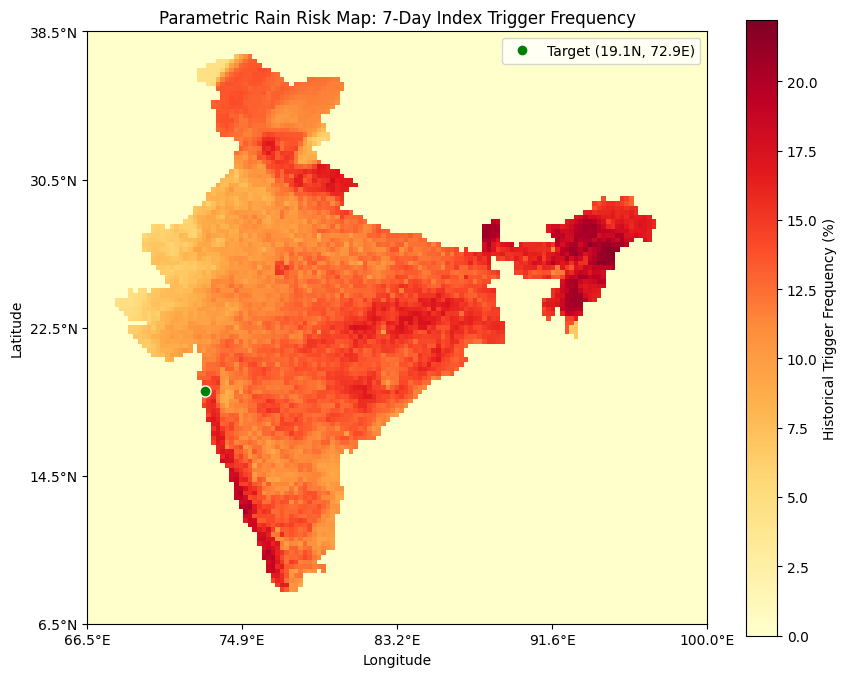

Heatmap generation complete.


In [11]:
# Then, run the historical risk assessment heatmap
create_payoff_frequency_heatmap(
    FINAL_HIGH_RAINFALL_THRESHOLD_MM,
    STD_DEV_MULTIPLIER,
    CUMULATIVE_DAYS
)

In [12]:
# =============================================================================
# 5. Stress Testing: Historical Loss Expectancy (EAL/MAL)
# =============================================================================

def calculate_historical_loss_expectancy(lat, lon, full_payout_threshold, std_multiplier, index_days, payout_amount_max):
    """
    Runs the full parametric logic against 30 years of historical data to 
    calculate Expected Annual Loss (EAL) and Maximum Annual Loss (MAL).
    """
    
    print(f"\n====================================================================")
    print(f"📈 STRESS TEST: HISTORICAL LOSS EXPECTANCY (EAL/MAL) 📈")
    print(f"Target: ({lat:.4f}°N, {lon:.4f}°E) | Historical Period: {LPA_START_YR}-{LPA_END_YR}")
    print(f"====================================================================")
    
    # 1. Load Data and Climatology
    if not ensure_historical_data_exists(DATA_DIR, LPA_START_YR, LPA_END_YR): return
    lpa_daily, std_dev_daily = get_climatological_data(lat, lon)
    if lpa_daily is None: return

    # Calculate Triggers
    lpa_cumulative = lpa_daily * index_days
    std_dev_cumulative = std_dev_daily * np.sqrt(index_days) 
    PARTIAL_PAYOUT_START_TRIGGER = lpa_cumulative + std_dev_cumulative * std_multiplier
    FULL_PAYOUT_TRIGGER = full_payout_threshold
    
    if PARTIAL_PAYOUT_START_TRIGGER >= FULL_PAYOUT_TRIGGER:
         PARTIAL_PAYOUT_START_TRIGGER = FULL_PAYOUT_TRIGGER * 0.75 

    # 2. Get Full Time Series Data for the point
    try:
        data = imd.open_data('rain', LPA_START_YR, LPA_END_YR, 'yearwise', file_dir=DATA_DIR)
        ds = data.get_xarray()
        regional_ds = ds.sel(lat=lat, lon=lon, method='nearest')['rain']
        rainfall_series = regional_ds.to_pandas().replace(-999.0, np.nan)
        
        # Calculate the 7-day rolling cumulative index for the full 30 years
        cumulative_series = rainfall_series.rolling(window=index_days, min_periods=index_days).sum().dropna()
        
    except Exception as e:
        print(f"Error loading historical time series: {e}")
        return

    # 3. Simulate Payouts for every day in the history
    historical_losses = {}
    
    for date, index_value in cumulative_series.items():
        year = date.year
        payout_level = 0.0
        
        # Payout Logic (Same as live engine)
        if index_value >= FULL_PAYOUT_TRIGGER:
            payout_level = 1.0 
        elif index_value > PARTIAL_PAYOUT_START_TRIGGER:
            payout_range = FULL_PAYOUT_TRIGGER - PARTIAL_PAYOUT_START_TRIGGER
            deviation = index_value - PARTIAL_PAYOUT_START_TRIGGER
            payout_level = min(1.0, max(0.0, deviation / payout_range))
            
        payout_amount = payout_level * payout_amount_max
        
        if payout_amount > 0:
            historical_losses.setdefault(year, 0)
            historical_losses[year] += payout_amount

    # 4. Calculate Final Metrics
    if not historical_losses:
        print("Historical analysis complete: NO PAYOUTS TRIGGERED in the 30-year period.")
        return

    # Total loss over the 30 years
    total_loss_expectancy = sum(historical_losses.values())
    
    # Expected Annual Loss (EAL) - The base premium cost
    expected_annual_loss = total_loss_expectancy / (LPA_END_YR - LPA_START_YR + 1)
    
    # Maximum Annual Loss (MAL) - The worst-case year
    maximum_annual_loss = max(historical_losses.values())
    worst_year = max(historical_losses, key=historical_losses.get)

    # 5. Output Financial Metrics
    print("\n--- Historical Loss Analysis ---")
    print(f"Total Years Analyzed: {LPA_END_YR - LPA_START_YR + 1}")
    print(f"Partial Trigger: {PARTIAL_PAYOUT_START_TRIGGER:.2f} mm | Full Trigger: {FULL_PAYOUT_TRIGGER:.2f} mm")
    print("--------------------------------")
    print(f"Total Loss Expectancy (30yr HLE): {total_loss_expectancy:,.2f}")
    print(f"💸 Expected Annual Loss (EAL): {expected_annual_loss:,.2f} (Base Premium)")
    print(f"🔥 Maximum Annual Loss (MAL): {maximum_annual_loss:,.2f} (Worst Year: {worst_year})")
    print("--------------------------------")
    print("Historical losses by year (Payouts Triggered):")
    for year, loss in sorted(historical_losses.items()):
        print(f"  {year}: {loss:,.2f}")

    print("Stress Testing complete.")


In [13]:
calculate_historical_loss_expectancy(
        TARGET_LAT, 
        TARGET_LON, 
        FINAL_HIGH_RAINFALL_THRESHOLD_MM,
        STD_DEV_MULTIPLIER,
        CUMULATIVE_DAYS,
        FULL_PAYOUT_AMOUNT
    )


📈 STRESS TEST: HISTORICAL LOSS EXPECTANCY (EAL/MAL) 📈
Target: (19.0760°N, 72.8777°E) | Historical Period: 1981-2010

--- Ensuring Historical IMD Data (1981-2010) is Local ---
All historical data files already exist locally. Skipping download.

--- Calculating Climatological LPA and Std Dev ---
Nearest Grid Point Data Size: 10957 days

--- Historical Loss Analysis ---
Total Years Analyzed: 30
Partial Trigger: 131.37 mm | Full Trigger: 150.00 mm
--------------------------------
Total Loss Expectancy (30yr HLE): 14,648,572.60
💸 Expected Annual Loss (EAL): 488,285.75 (Base Premium)
🔥 Maximum Annual Loss (MAL): 722,693.06 (Worst Year: 2010)
--------------------------------
Historical losses by year (Payouts Triggered):
  1981: 421,307.84
  1982: 348,551.73
  1983: 655,067.18
  1984: 425,148.50
  1985: 497,200.84
  1986: 318,873.82
  1987: 449,976.88
  1988: 650,636.19
  1989: 468,945.07
  1990: 689,438.58
  1991: 406,436.18
  1992: 417,762.85
  1993: 646,770.35
  1994: 637,459.53
  1995: 3